In [1]:
%matplotlib inline
from mpl_toolkits import mplot3d # 三维画图需要的
import matplotlib.pyplot as plt

import random

import numpy as np
import torch
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE' # plt绘图报错（不显示图的问题）
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

# 线性回归

## 生成数据集
用权重w=[2, -3.4] 和偏差b=4.2,特征2维， 来生成标签y~N(0,1)


In [2]:
num_inputs = 2
num_examples = 1000
# size = num_examples * num_inputs
true_w = torch.tensor([2, -3.4])
true_b = torch.tensor([4.2])

In [3]:
features = torch.randn(num_examples, num_inputs,
                       dtype=torch.float32)

In [4]:
# y = xw + b
# labels_without_noise_1 = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels_without_noise = features@true_w.t() + true_b

In [5]:
# y = xw+b + 高斯噪音
# np.random.normal(0, 0.01, size=labels_without_noise.size())
labels_noise = torch.tensor(torch.normal(0, 0.01, size=labels_without_noise.size()),
                       dtype=torch.float32)

labels_with_noise = labels_without_noise+labels_noise

<ipython-input-5-d7fcd44177cf>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_noise = torch.tensor(torch.normal(0, 0.01, size=labels_without_noise.size()),


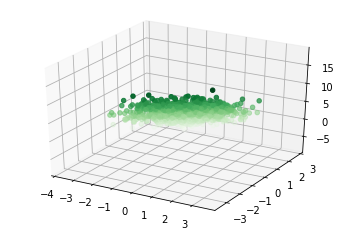

In [6]:
ax = plt.axes(projection='3d')
# 三维散点的数据
ax.scatter3D(features[:,0], features[:,1], labels_with_noise, c=labels_with_noise, cmap='Greens')

In [7]:
# 它每次返回batch_size（批量大小）个随机样本的特征和标签。
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(indices[i: min(i + batch_size, num_examples)]) # 最后一次可能不足一个batch
        yield  features.index_select(0, j), labels.index_select(0, j)


for X, y in data_iter(10, features, labels_with_noise):
    print(X, y)
    break


tensor([[-0.7840,  0.2667],
        [ 0.1696, -0.1565],
        [-0.9166,  0.8553],
        [-0.6180, -0.5544],
        [-0.4589,  0.1216],
        [-0.2838,  1.5616],
        [-0.0330, -0.2158],
        [ 0.5310, -2.0281],
        [-1.0066,  0.7044],
        [ 2.1873, -0.8829]]) tensor([ 1.7034,  5.0786, -0.5306,  4.8348,  2.8816, -1.6764,  4.8680, 12.1431,
        -0.2067, 11.5915])


In [8]:
# 定义模型
def linreg(X, w, b):
    return torch.mm(X, w) + b #X@w + b

# 定义损失函数
def squared_loss(y_hat, y):
    # 注意这里返回的是向量, 另外, pytorch里的MSELoss并没有除以 2
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

# 定义优化算法
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size # 注意这里更改param时用的param.data


In [9]:
# w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
# b = torch.zeros(1, dtype=torch.float32)
# 初始化参数：可以随机
w = torch.tensor([[0],[0]],dtype=torch.float32,requires_grad=True)
b = torch.zeros(1, dtype=torch.float32)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

In [10]:
# 训练模型

lr = 0.03
batch_size = 10
num_epochs = 3 # 完整数据集迭代次数
net = linreg
loss = squared_loss

for epoch in range(num_epochs):  # 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # 和y分别是小批量样本的特征和标签
    for X, y in data_iter(batch_size, features, labels_with_noise):
        l = loss(net(X, w, b), y).sum()  # l是有关小批量X和y的损失
        l.backward()  # 小批量的损失对模型参数求梯度
        sgd([w, b], lr, batch_size)  # 使用小批量随机梯度下降迭代模型参数

        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b), labels_with_noise)
    print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1, loss 0.029474
epoch 2, loss 0.000103
epoch 3, loss 0.000049


In [11]:
print(true_w, '~', w)
print(true_b, '~', b)

tensor([ 2.0000, -3.4000]) ~ tensor([[ 2.0000],
        [-3.3997]], requires_grad=True)
tensor([4.2000]) ~ tensor([4.1985], requires_grad=True)
